In [1]:
!nvidia-smi

Tue May  9 09:25:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   35C    P0    54W / 300W |  18558MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:16:00.0 Off |                    0 |
| N/A   

In [1]:
#stl
import os
import warnings
from tqdm import tqdm

#data handling
import pandas as pd
import numpy as np

#stats
import scipy
import sklearn

#network
import networkx as nx

#vis
import matplotlib.pyplot as plt
import seaborn as sns

#torch

sns.set(font_scale = 1.5)
sns.set_theme()

In [2]:
#deep learning STL
import torch
import torch.nn.functional as F
from torch.nn import BatchNorm1d 
from torch.nn import Linear


#accuracy metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

#5 fold CV
from sklearn.model_selection import StratifiedKFold

#collections
import collections 
import collections.abc

#iteration tracking
from tqdm import tqdm

## Supervised MLP on Raw Data (Training Preprocessing Layers)

In [3]:
DILI_DATA = pd.read_csv("graph_data/FINAL_DILI_DATA.csv", index_col = [0])
DILI_DATA

,Compound Name,DILI (+/-),DILI Risk,MitoTox (Seahorse)::% Inhibition (Basal Respiration),MitoTox (Seahorse)::% Inhibition (Max Respiration),MitoTox (Seahorse)::Risk\n(based on old values),Long-term Cytotoxicity_(hLiMT)::7 Day Compiled_IC50 (uM),(GNE) Cytotoxicity_Primary Human Hepatocytes::IC50 (uM),MW,TPSA,...,Exposure Bin (>1<),Adjusted Long-term Cytotoxicity_(hLiMT)::7 day_IC50 (uM),Adjusted Cytotoxicity_Primary Human Hepatocytes IC50 (uM),MOS :: hLiMTs,MOS :: PHH,Adjusted BSEP::IC50 (uM),Adjusted MitoTox (Seahorse)::% Inhibition (Basal Respiration,Adjusted MitoTox (Seahorse)::% Inhibition (Max Respiration),MOS :: BSEP,DBID
19,Benzatropine,0,1,-2.589729,15.770685,1,23.84,27.76,307.43,12.0,...,0,23.84,27.76,40.752137,47.452991,100000.00,0.0001,18.9000,170940.170940,DB00245
23,Bromfenac,1,0,38.551592,42.890777,2,100.00,100.00,334.16,80.0,...,1,100000.00,100000.00,4166.666667,4166.666667,100000.00,40.0000,43.0000,4166.666667,DB00963
80,Isoniazid,1,0,2.865409,0.354520,1,100.00,100.00,137.14,68.0,...,1,100000.00,100000.00,917.431193,917.431193,100000.00,0.9000,2.9000,917.431193,DB00951
89,Lumiracoxib,1,0,3.120935,20.164061,1,100.00,100.00,293.72,49.0,...,1,100000.00,100000.00,3225.806452,3225.806452,100000.00,10.4000,28.1000,3225.806452,DB01283
102,Nefazodone,1,0,55.869854,90.440380,0,25.30,56.39,470.01,55.0,...,1,25.30,56.39,5.883721,13.113953,10.84,63.8000,92.4000,2.520930,DB01149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,tretinoin,0,1,25.381273,70.342548,0,29.20,100.00,300.44,37.0,...,1,29.20,100000.00,21.938392,75131.480090,54.61,32.7000,74.6000,41.029301,DB00755
163,trovafloxacin,1,0,35.801739,35.602111,2,125.00,125.00,416.35,101.0,...,1,100000.00,100000.00,19920.318725,19920.318725,100000.00,41.5000,42.9000,19920.318725,DB00685
165,verapamil,0,1,19.627111,29.970451,1,51.85,47.84,454.60,63.0,...,0,51.85,47.84,94.289871,86.997636,100000.00,26.5000,38.0000,181851.245681,DB00661
166,warfarin,1,2,-2.295602,19.397812,1,100.00,100.00,308.33,60.0,...,1,100000.00,100000.00,11904.761905,11904.761905,100000.00,0.0001,0.0001,11904.761905,DB00682


In [4]:
DILI_DATA["DILI (+/-)"].value_counts()

0    75
1    60
Name: DILI (+/-), dtype: int64

In [5]:
labels = DILI_DATA["DILI (+/-)"].to_numpy()

In [6]:
#get rid of the labels
features = DILI_DATA[DILI_DATA.columns[3:]]
#get rid of the DBID
features = features[features.columns[:-1]]

features = features.to_numpy()
features.shape

(135, 45)

** Normalize the Data **

In [7]:
from sklearn.preprocessing import StandardScaler

#values are continuous
sc = StandardScaler()
#sc_features = sc.fit_transform(features)
sc_features = features

** 80/20 Train Test Split **

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(sc_features, labels, test_size=0.2, stratify = labels)

** Model **

In [10]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers: int, output = 1):
        super(MLP, self).__init__()
        self.input = torch.nn.Linear(input_dim, hidden_dim)
        self.lin_layers = torch.nn.ModuleList([torch.nn.Linear(hidden_dim, hidden_dim) for i in range(num_layers)])
        self.output = torch.nn.Linear(hidden_dim, output)
        self.dropout = torch.nn.Dropout(0.10)

    def forward(self, x):
        x = self.input(x).relu()
        x = self.dropout(x)
        
        for layer in self.lin_layers:
            x = layer(x).relu()
            x = self.dropout(x)
            
        x = self.output(x)
        return x

** Model Training (5-fold CV) **

In [11]:
train_metric_list = []
test_metric_list = []

model_list = [MLP(input_dim = 45, hidden_dim = 135, num_layers = 5)
              for i in range(5)]
skf = StratifiedKFold(n_splits=5)
for i, (train_index, test_index) in enumerate(skf.split(sc_features, labels)):

    model = model_list[i]
    num_epochs = 500
    threshold = 0.5
    l_r = 0.0001
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = torch.FloatTensor([1.]))
    optimizer = torch.optim.Adam(model.parameters(), lr = l_r)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_epochs)
    
    #preparation
    x_train, x_test = sc_features[train_index], sc_features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    device = "cuda:0"
    x_train, x_test = torch.from_numpy(x_train).to(device), torch.from_numpy(x_test).to(device)
    y_train, y_test = torch.FloatTensor(y_train).unsqueeze(dim = 1).to(device), torch.FloatTensor(y_test).unsqueeze(dim = 1).to(device)
    loss_fn.to(device)
    model = model.double().to(device)


    for epoch in tqdm(range(num_epochs), desc = "Fold %i" % (i+1)):
        optimizer.zero_grad()
        out = model(x_train)
        loss = loss_fn(out, y_train)
        loss.backward()
        optimizer.step()
        scheduler.step()

        probs = torch.sigmoid(out.detach()).cpu().numpy()
        y_preds = (probs >= threshold).astype(int)

        accuracy = accuracy_score(y_true = y_train.cpu().numpy(), y_pred = y_preds)
        try:
            auc = roc_auc_score(y_true = y_train.cpu().numpy(), y_score = y_preds)
        except ValueError:
            auc = 0.500
        f1 = f1_score(y_true = y_train.cpu().numpy(), y_pred = y_preds)
        precision = precision_score(y_true = y_train.cpu().numpy(), y_pred = y_preds, zero_division = 0)
        recall = recall_score(y_true = y_train.cpu().numpy(), y_pred = y_preds)

    train_metric_list.append([accuracy, auc, f1, precision, recall])
    print(f"Train Accuracy: {accuracy:.5f}, Train AUC: {auc:.5f}, Train Precision: {precision:.5f}, Train Recall: {recall:.5f}, Train F1: {f1:.5f}")

    #EVALUATE USING EVAL SET
    model.eval()
    out = model(x_test)

    probs = torch.sigmoid(out.detach()).cpu().numpy()
    y_preds = (probs >= threshold).astype(int)

    accuracy = accuracy_score(y_true = y_test.cpu().numpy(), y_pred = y_preds)
    try:
        auc = roc_auc_score(y_true = y_test.cpu().numpy(), y_score = y_preds)
    except ValueError:
        auc = 0.500
    f1 = f1_score(y_true = y_test.cpu().numpy(), y_pred = y_preds)
    precision = precision_score(y_true = y_test.cpu().numpy(), y_pred = y_preds, zero_division = 0)
    recall = recall_score(y_true = y_test.cpu().numpy(), y_pred = y_preds)

    test_metric_list.append([accuracy, auc, f1, precision, recall])
    print(f"Test Accuracy: {accuracy:.5f}, Test AUC: {auc:.5f}, Test Precision: {precision:.5f}, Test Recall: {recall:.5f}, Test F1: {f1:.5f}")

Fold 1: 100%|██████████| 500/500 [00:03<00:00, 165.29it/s]


Train Accuracy: 0.64815, Train AUC: 0.64167, Train Precision: 0.60870, Train Recall: 0.58333, Train F1: 0.59574
Test Accuracy: 0.55556, Test AUC: 0.58333, Test Precision: 0.50000, Test Recall: 0.83333, Test F1: 0.62500


Fold 2: 100%|██████████| 500/500 [00:02<00:00, 178.64it/s]


Train Accuracy: 0.62963, Train AUC: 0.62083, Train Precision: 0.59091, Train Recall: 0.54167, Train F1: 0.56522
Test Accuracy: 0.62963, Test AUC: 0.60000, Test Precision: 0.66667, Test Recall: 0.33333, Test F1: 0.44444


Fold 3: 100%|██████████| 500/500 [00:02<00:00, 180.28it/s]


Train Accuracy: 0.65741, Train AUC: 0.65208, Train Precision: 0.61702, Train Recall: 0.60417, Train F1: 0.61053
Test Accuracy: 0.77778, Test AUC: 0.77500, Test Precision: 0.75000, Test Recall: 0.75000, Test F1: 0.75000


Fold 4: 100%|██████████| 500/500 [00:02<00:00, 178.92it/s]


Train Accuracy: 0.66667, Train AUC: 0.65000, Train Precision: 0.66667, Train Recall: 0.50000, Train F1: 0.57143
Test Accuracy: 0.66667, Test AUC: 0.64167, Test Precision: 0.71429, Test Recall: 0.41667, Test F1: 0.52632


Fold 5: 100%|██████████| 500/500 [00:02<00:00, 179.70it/s]

Train Accuracy: 0.65741, Train AUC: 0.64792, Train Precision: 0.62791, Train Recall: 0.56250, Train F1: 0.59341
Test Accuracy: 0.51852, Test AUC: 0.50000, Test Precision: 0.44444, Test Recall: 0.33333, Test F1: 0.38095


In [12]:
train_df = pd.DataFrame(train_metric_list)
test_df = pd.DataFrame(test_metric_list)

train_df.index = ["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"]
test_df.index = ["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"]

train_df.columns = ["Accuracy", "AUC", "F1", "Precision", "Recall"]
test_df.columns = ["Accuracy", "AUC", "F1", "Precision", "Recall"]

train_df.loc['AVG'] = train_df.mean()
test_df.loc['AVG'] = test_df.mean()

In [13]:
train_df

,Accuracy,AUC,F1,Precision,Recall
Fold 1,0.648148,0.641667,0.595745,0.608696,0.583333
Fold 2,0.629630,0.620833,0.565217,0.590909,0.541667
Fold 3,0.657407,0.652083,0.610526,0.617021,0.604167
Fold 4,0.666667,0.650000,0.571429,0.666667,0.500000
Fold 5,0.657407,0.647917,0.593407,0.627907,0.562500
AVG,0.651852,0.642500,0.587265,0.622240,0.558333


In [14]:
test_df

,Accuracy,AUC,F1,Precision,Recall
Fold 1,0.555556,0.583333,0.625000,0.500000,0.833333
Fold 2,0.629630,0.600000,0.444444,0.666667,0.333333
Fold 3,0.777778,0.775000,0.750000,0.750000,0.750000
Fold 4,0.666667,0.641667,0.526316,0.714286,0.416667
Fold 5,0.518519,0.500000,0.380952,0.444444,0.333333
AVG,0.629630,0.620000,0.545343,0.615079,0.533333


** Extracting Hidden Layers **

In [15]:
model_list[0]

MLP(
  (input): Linear(in_features=45, out_features=135, bias=True)
  (lin_layers): ModuleList(
    (0): Linear(in_features=135, out_features=135, bias=True)
    (1): Linear(in_features=135, out_features=135, bias=True)
    (2): Linear(in_features=135, out_features=135, bias=True)
    (3): Linear(in_features=135, out_features=135, bias=True)
    (4): Linear(in_features=135, out_features=135, bias=True)
  )
  (output): Linear(in_features=135, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [16]:
pretrained_input_layer = list(model.children())[0]
pretrained_module_list = list(model.children())[1]

In [17]:
pretrained_input_layer

Linear(in_features=45, out_features=135, bias=True)

## Deep Graph Infomax

In [18]:
#append features
mikg_features = np.load("graph_data/NODE_FEATURES.npy").tolist()
drug_features = features.tolist()

In [19]:
np.array(mikg_features).shape

(18120, 135)

In [20]:
for i in range(len(drug_features)):
    padding = np.zeros(90).tolist()
    drug_features[i] = drug_features[i] + padding
    
np.array(drug_features).shape

(135, 135)

In [21]:
final_features = mikg_features + drug_features
final_features = np.array(final_features)
final_features.shape

(18255, 135)

~the last 135 features are all padded features~ --> they are the drug nodes

we will remove the padding during model training

** pyG Graph **

In [22]:
FILTERED_MIKG = "/gstore/data/dsi_ai_analytics/projects/nlp/AMD/Data/df_all_nodes_realations_1.csv"
FILTERED_MIKG = pd.read_csv(FILTERED_MIKG, index_col = [0])
FILTERED_MIKG = FILTERED_MIKG[["node_1_name", "relation", "node_2_name"]]
FILTERED_MIKG

,node_1_name,relation,node_2_name
14,sunitinib,drug-protein,CSF1R
25,dronedarone,drug-protein,ADRB1
26,desipramine,drug-protein,ADRB1
41,propranolol,drug-protein,ADRB1
44,olanzapine,drug-protein,ADRB1
...,...,...,...
5330,Ximelagatran,drug-indication,thrombosis
5590,benzbromarone,drug-indication,gout
5672,droxicam,drug-indication,rheumatoid arthritis
5673,droxicam,drug-indication,osteoarthritis


In [23]:
node_mapping = pd.read_csv("graph_data/MIKG_mapping.csv", index_col = [0])
node_mapping = dict(zip(node_mapping["name"], node_mapping["id"]))
node_mapping

{'CEP72': 0,
 'PIK3CG': 1,
 'MYOG': 2,
 'SLC27A6': 3,
 'NRAS': 4,
 'PRDX2': 5,
 'PRC1': 6,
 'AGA': 7,
 'CACNB4': 8,
 'ASCL2': 9,
 'STRAP': 10,
 'HGS': 11,
 'ABCF2': 12,
 'PRKAR1B': 13,
 'LGALS1': 14,
 'PFKFB3': 15,
 'CWF19L2': 16,
 'UBE2W': 17,
 'DDR2': 18,
 'WIPI1': 19,
 'TOLLIP': 20,
 'RNMT': 21,
 'CEL': 22,
 'ABL2': 23,
 'TNRC18': 24,
 'HSPA8': 25,
 'URGCP': 26,
 'SIRPA': 27,
 'TCP10L': 28,
 'EHD1': 29,
 'SLC39A1': 30,
 'ARHGAP20': 31,
 'ABCG2': 32,
 'RRP15': 33,
 'ASCC1': 34,
 'ANGPTL2': 35,
 'CCDC47': 36,
 'VWA8': 37,
 'LRSAM1': 38,
 'SDCBP2': 39,
 'BCL3': 40,
 'MAPKAPK2': 41,
 'EIF1B': 42,
 'NCOA6': 43,
 'LIN7A': 44,
 'HSPA4L': 45,
 'CWC15': 46,
 'ALOXE3': 47,
 'MPPED2': 48,
 'PSMA8': 49,
 'PRRT4': 50,
 'KCNE4': 51,
 'ECI2': 52,
 'DHCR24': 53,
 'BAHD1': 54,
 'HJURP': 55,
 'KCNA2': 56,
 'MRPS18B': 57,
 'PSTPIP2': 58,
 'ATP5IF1': 59,
 'RBM22': 60,
 'ORM2': 61,
 'ARHGAP32': 62,
 'GPATCH8': 63,
 'RPF1': 64,
 'JAGN1': 65,
 'MYL6': 66,
 'PMM2': 67,
 'TMEM63B': 68,
 'GABARAPL1': 69,
 'A

In [24]:
FILTERED_MIKG = FILTERED_MIKG.replace({"node_1_name" : node_mapping, "node_2_name" : node_mapping})
FILTERED_MIKG["weight"] = 1
FILTERED_MIKG

,node_1_name,relation,node_2_name,weight
14,18240,drug-protein,1820,1
25,18173,drug-protein,4848,1
26,18167,drug-protein,4848,1
41,18235,drug-protein,4848,1
44,18216,drug-protein,4848,1
...,...,...,...,...
5330,18134,drug-indication,8801,1
5590,18146,drug-indication,8929,1
5672,18174,drug-indication,8951,1
5673,18174,drug-indication,8919,1


In [36]:
weight = FILTERED_MIKG["weight"].to_list()
new_src = FILTERED_MIKG["node_1_name"].to_list() + FILTERED_MIKG["node_2_name"].to_list()
new_dest = FILTERED_MIKG["node_2_name"].to_list() + FILTERED_MIKG["node_1_name"].to_list()
weight = weight + weight

In [37]:
final_edge_index = torch.LongTensor((new_src, new_dest))
final_weight = torch.Tensor(weight)
final_num_nodes = int(18255)
x = torch.DoubleTensor(final_features)

In [38]:
from torch_geometric.data import Data

graph = Data()
graph.x = x
graph.edge_index = final_edge_index
graph.weight = final_weight
graph.num_nodes = final_num_nodes

In [39]:
graph.edge_index.type()

'torch.LongTensor'

In [40]:
graph.weight.type()

'torch.FloatTensor'

In [41]:
graph.x.type()

'torch.DoubleTensor'

In [42]:
graph.x[-135:, :45].shape

torch.Size([135, 45])

** model **

In [43]:
#deep learning STL
import torch
import torch.nn.functional as F
from torch.nn import BatchNorm1d 
from torch.nn import Linear

#data loading
from torch_geometric.loader import DataLoader

#parallel
from torch_geometric.nn import DataParallel
from torch_geometric.loader import DataListLoader


#layers
from torch_geometric.nn import GCNConv
from torch_geometric.nn.conv import GATConv
from torch_geometric.nn.conv import SAGEConv

#model
from torch_geometric.nn.models import DeepGraphInfomax

#pooling methods
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_max_pool
#from torch_geometric.nn import global_min_pool

#accuracy metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

#5 fold CV
from sklearn.model_selection import StratifiedKFold

#collections
import collections 
import collections.abc

#iteration tracking
from tqdm import tqdm

In [44]:
class Encoder(torch.nn.Module):
    def __init__(self,                  
                 pretrained_input_layer = pretrained_input_layer,
                 pretrained_mlp_layers = pretrained_module_list,
                 node_features = 135,
                 hidden_channels = 200, 
                 out_channels = 164):

        super(Encoder, self).__init__()
        
        self.pretrained_input_layer = pretrained_input_layer
        self.pretrained_mlp_layers = pretrained_mlp_layers
        
        self.Sage1 = SAGEConv(node_features, hidden_channels, normalize = True)
        self.Sage2 = SAGEConv(hidden_channels, hidden_channels, normalize = True)
        self.Sage3 = SAGEConv(hidden_channels, hidden_channels, normalize = True)
        self.Sage4 = SAGEConv(hidden_channels, hidden_channels, normalize = True)
        self.Sage5 = SAGEConv(hidden_channels, hidden_channels, normalize = True)
        self.Sage6 = SAGEConv(hidden_channels, hidden_channels, normalize = True)
        self.Sage7 = SAGEConv(hidden_channels, hidden_channels, normalize = True)
        self.Sage8 = SAGEConv(hidden_channels, hidden_channels, normalize = True)
        self.lin_out = Linear(hidden_channels, out_channels)
        self.batch_norm = BatchNorm1d(hidden_channels)
        
        #remove the gradients
        for k, v in self.named_parameters():
            if k.startswith("pretrained"):
                v.requires_grad = False

    def forward(self, x, edge_index):
        
        mikg_features, drug_features = torch.split(x, [18120, 135])
        drug_features, _ = torch.split(drug_features, [45, 90], dim = 1)
        
        #run drug features through this
        drug_features = self.pretrained_input_layer(drug_features).relu()
        for layer in self.pretrained_mlp_layers:
            drug_features = layer(drug_features).relu()
        
        #concatenate
        x = torch.cat([mikg_features, drug_features], dim=0)
        
        #run through the rest of the encoders
        x = self.Sage1(x, edge_index).relu()
        x = self.Sage2(x, edge_index).relu()
        x = self.Sage3(x, edge_index).relu()
        x = self.Sage4(x, edge_index).relu()
        x = self.Sage5(x, edge_index).relu()
        x = self.Sage6(x, edge_index).relu()
        x = self.Sage7(x, edge_index).relu()
        x = self.Sage8(x, edge_index).relu()
        x = self.batch_norm(x)
        x = F.normalize(x, p=2, dim=1)
        x = self.lin_out(x)
        x = F.normalize(x, p=2, dim=1)
        return x

In [45]:
def corruption(x, edge_index):
    return x[torch.randperm(x.size(0))], edge_index

In [46]:
device = torch.device('cuda:1')

In [47]:
model = DeepGraphInfomax(
    hidden_channels = 164, encoder = Encoder().double(),
    summary=lambda z, *args, **kwargs: torch.sigmoid(z.mean(dim=0)),
    corruption = corruption).to(device).double()

graph = graph.to(device)

In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 1000)

In [49]:
def train():
    model.train()
    optimizer.zero_grad()
    pos_z, neg_z, summary = model(graph.x, graph.edge_index)
    loss = model.loss(pos_z, neg_z, summary)

    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()

In [50]:
loss_list = []
for epoch in range(1, 1000):
    loss = train()
    loss_list.append(loss)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.3402
Epoch: 002, Loss: 1.2930
Epoch: 003, Loss: 1.2438
Epoch: 004, Loss: 1.2166
Epoch: 005, Loss: 1.1713
Epoch: 006, Loss: 1.1442
Epoch: 007, Loss: 1.1084
Epoch: 008, Loss: 1.0724
Epoch: 009, Loss: 1.0445
Epoch: 010, Loss: 1.0080
Epoch: 011, Loss: 0.9724
Epoch: 012, Loss: 0.9391
Epoch: 013, Loss: 0.9051
Epoch: 014, Loss: 0.8939
Epoch: 015, Loss: 0.8469
Epoch: 016, Loss: 0.8125
Epoch: 017, Loss: 0.7765
Epoch: 018, Loss: 0.7548
Epoch: 019, Loss: 0.7167
Epoch: 020, Loss: 0.6939
Epoch: 021, Loss: 0.6568
Epoch: 022, Loss: 0.6302
Epoch: 023, Loss: 0.6032
Epoch: 024, Loss: 0.5761
Epoch: 025, Loss: 0.5525
Epoch: 026, Loss: 0.5317
Epoch: 027, Loss: 0.5005
Epoch: 028, Loss: 0.4712
Epoch: 029, Loss: 0.4494
Epoch: 030, Loss: 0.4318
Epoch: 031, Loss: 0.4103
Epoch: 032, Loss: 0.3971
Epoch: 033, Loss: 0.3872
Epoch: 034, Loss: 0.3636
Epoch: 035, Loss: 0.3533
Epoch: 036, Loss: 0.3365
Epoch: 037, Loss: 0.3306
Epoch: 038, Loss: 0.3036
Epoch: 039, Loss: 0.2913
Epoch: 040, Loss: 0.2725


Epoch: 329, Loss: 0.0012
Epoch: 330, Loss: 0.0013
Epoch: 331, Loss: 0.0015
Epoch: 332, Loss: 0.0012
Epoch: 333, Loss: 0.0013
Epoch: 334, Loss: 0.0012
Epoch: 335, Loss: 0.0012
Epoch: 336, Loss: 0.0020
Epoch: 337, Loss: 0.0012
Epoch: 338, Loss: 0.0012
Epoch: 339, Loss: 0.0012
Epoch: 340, Loss: 0.0012
Epoch: 341, Loss: 0.0012
Epoch: 342, Loss: 0.0012
Epoch: 343, Loss: 0.0012
Epoch: 344, Loss: 0.0012
Epoch: 345, Loss: 0.0014
Epoch: 346, Loss: 0.0013
Epoch: 347, Loss: 0.0012
Epoch: 348, Loss: 0.0011
Epoch: 349, Loss: 0.0011
Epoch: 350, Loss: 0.0011
Epoch: 351, Loss: 0.0011
Epoch: 352, Loss: 0.0011
Epoch: 353, Loss: 0.0011
Epoch: 354, Loss: 0.0011
Epoch: 355, Loss: 0.0011
Epoch: 356, Loss: 0.0011
Epoch: 357, Loss: 0.0011
Epoch: 358, Loss: 0.0011
Epoch: 359, Loss: 0.0011
Epoch: 360, Loss: 0.0013
Epoch: 361, Loss: 0.0010
Epoch: 362, Loss: 0.0011
Epoch: 363, Loss: 0.0010
Epoch: 364, Loss: 0.0011
Epoch: 365, Loss: 0.0010
Epoch: 366, Loss: 0.0013
Epoch: 367, Loss: 0.0010
Epoch: 368, Loss: 0.0010


Epoch: 657, Loss: 0.0007
Epoch: 658, Loss: 0.0006
Epoch: 659, Loss: 0.0006
Epoch: 660, Loss: 0.0006
Epoch: 661, Loss: 0.0006
Epoch: 662, Loss: 0.0006
Epoch: 663, Loss: 0.0006
Epoch: 664, Loss: 0.0006
Epoch: 665, Loss: 0.0006
Epoch: 666, Loss: 0.0006
Epoch: 667, Loss: 0.0006
Epoch: 668, Loss: 0.0006
Epoch: 669, Loss: 0.0006
Epoch: 670, Loss: 0.0006
Epoch: 671, Loss: 0.0006
Epoch: 672, Loss: 0.0006
Epoch: 673, Loss: 0.0006
Epoch: 674, Loss: 0.0006
Epoch: 675, Loss: 0.0006
Epoch: 676, Loss: 0.0006
Epoch: 677, Loss: 0.0005
Epoch: 678, Loss: 0.0005
Epoch: 679, Loss: 0.0005
Epoch: 680, Loss: 0.0005
Epoch: 681, Loss: 0.0005
Epoch: 682, Loss: 0.0008
Epoch: 683, Loss: 0.0006
Epoch: 684, Loss: 0.0006
Epoch: 685, Loss: 0.0005
Epoch: 686, Loss: 0.0005
Epoch: 687, Loss: 0.0005
Epoch: 688, Loss: 0.0005
Epoch: 689, Loss: 0.0006
Epoch: 690, Loss: 0.0005
Epoch: 691, Loss: 0.0006
Epoch: 692, Loss: 0.0005
Epoch: 693, Loss: 0.0005
Epoch: 694, Loss: 0.0006
Epoch: 695, Loss: 0.0005
Epoch: 696, Loss: 0.0005


Epoch: 985, Loss: 0.0005
Epoch: 986, Loss: 0.0005
Epoch: 987, Loss: 0.0005
Epoch: 988, Loss: 0.0005
Epoch: 989, Loss: 0.0005
Epoch: 990, Loss: 0.0005
Epoch: 991, Loss: 0.0005
Epoch: 992, Loss: 0.0005
Epoch: 993, Loss: 0.0005
Epoch: 994, Loss: 0.0005
Epoch: 995, Loss: 0.0005
Epoch: 996, Loss: 0.0005
Epoch: 997, Loss: 0.0005
Epoch: 998, Loss: 0.0005
Epoch: 999, Loss: 0.0005


<AxesSubplot:title={'center':'Deep Graph Infomax - Loss Plot'}>

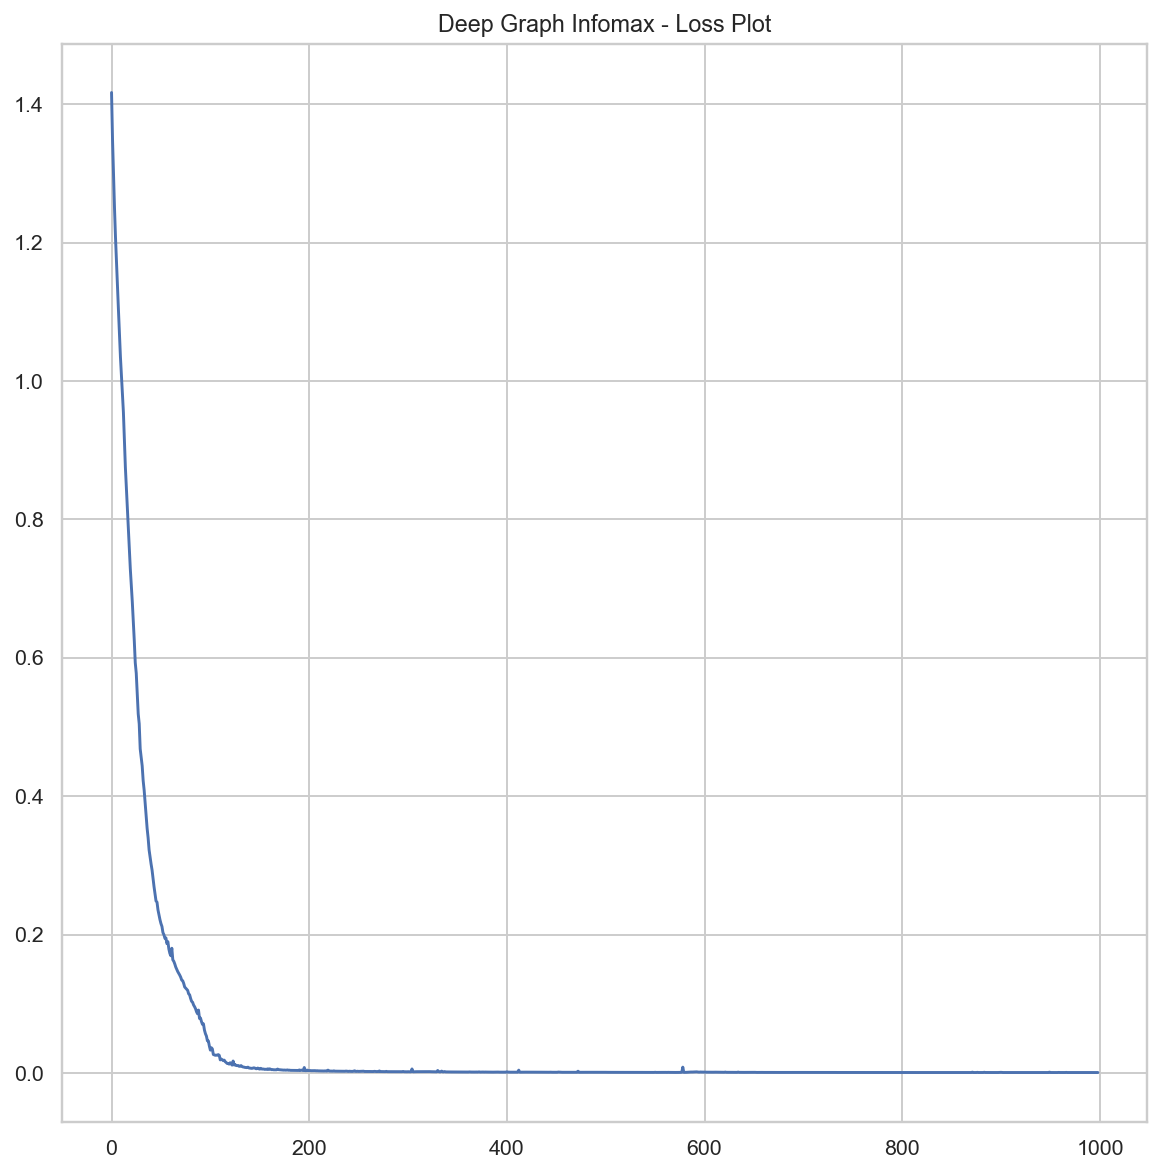

In [41]:
plt.figure(figsize = (10, 10), dpi = 140)
sns.set_style('whitegrid')
plt.title("Deep Graph Infomax - Loss Plot")
sns.lineplot(loss_list)

## GNN Explainer!

** rewriting GNNExplainer so that the node mask is only 45 features **

In [42]:
from math import sqrt
from typing import Optional

import torch
from tqdm import tqdm

from torch_geometric.nn.models.explainer import (
    Explainer,
    clear_masks,
    set_masks,
)

EPS = 1e-15


class new_GNNExplainer(Explainer):
    r"""The GNN-Explainer model from the `"GNNExplainer: Generating
    Explanations for Graph Neural Networks"
    <https://arxiv.org/abs/1903.03894>`_ paper for identifying compact subgraph
    structures and small subsets node features that play a crucial role in a
    GNN’s node-predictions.

    .. note::

        For an example of using GNN-Explainer, see `examples/gnn_explainer.py
        <https://github.com/pyg-team/pytorch_geometric/blob/master/examples/
        gnn_explainer.py>`_.

    Args:
        model (torch.nn.Module): The GNN module to explain.
        epochs (int, optional): The number of epochs to train.
            (default: :obj:`100`)
        lr (float, optional): The learning rate to apply.
            (default: :obj:`0.01`)
        num_hops (int, optional): The number of hops the :obj:`model` is
            aggregating information from.
            If set to :obj:`None`, will automatically try to detect this
            information based on the number of
            :class:`~torch_geometric.nn.conv.message_passing.MessagePassing`
            layers inside :obj:`model`. (default: :obj:`None`)
        return_type (str, optional): Denotes the type of output from
            :obj:`model`. Valid inputs are :obj:`"log_prob"` (the model
            returns the logarithm of probabilities), :obj:`"prob"` (the
            model returns probabilities), :obj:`"raw"` (the model returns raw
            scores) and :obj:`"regression"` (the model returns scalars).
            (default: :obj:`"log_prob"`)
        feat_mask_type (str, optional): Denotes the type of feature mask
            that will be learned. Valid inputs are :obj:`"feature"` (a single
            feature-level mask for all nodes), :obj:`"individual_feature"`
            (individual feature-level masks for each node), and :obj:`"scalar"`
            (scalar mask for each each node). (default: :obj:`"feature"`)
        allow_edge_mask (boolean, optional): If set to :obj:`False`, the edge
            mask will not be optimized. (default: :obj:`True`)
        log (bool, optional): If set to :obj:`False`, will not log any learning
            progress. (default: :obj:`True`)
        **kwargs (optional): Additional hyper-parameters to override default
            settings in :attr:`~torch_geometric.nn.models.GNNExplainer.coeffs`.
    """

    coeffs = { 
        'edge_size': 0.005,
        'edge_reduction': 'sum',
        'node_feat_size': 1.0,
        'node_feat_reduction': 'mean',
        'edge_ent': 1.0,
        'node_feat_ent': 0.1,
    }   

    def __init__(self, model, epochs: int = 200, lr: float = 0.001,
                 num_hops: Optional[int] = None, return_type: str = 'log_prob',
                 feat_mask_type: str = 'feature', allow_edge_mask: bool = True,
                 log: bool = True, **kwargs):
        super().__init__(model, lr, epochs, num_hops, return_type, log)
        assert feat_mask_type in ['feature', 'individual_feature', 'scalar']
        self.allow_edge_mask = allow_edge_mask
        self.feat_mask_type = feat_mask_type
        self.coeffs.update(kwargs)

    def _initialize_masks(self, x, edge_index, init="normal"):
        (N, F), E = x.size(), edge_index.size(1)
        std = 0.1
                    
        ########################################################################################
        #CHANGE SO THAT THE MASK IS ONLY 45
        F = 45
        ########################################################################################
        if self.feat_mask_type == 'individual_feature':
            self.node_feat_mask = torch.nn.Parameter(torch.randn(N, F) * std)
        elif self.feat_mask_type == 'scalar':
            self.node_feat_mask = torch.nn.Parameter(torch.randn(N, 1) * std)
        else:
            self.node_feat_mask = torch.nn.Parameter(torch.randn(1, F) * std)

        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))

        if self.allow_edge_mask:
            self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)

    def _clear_masks(self):
        clear_masks(self.model)
        self.node_feat_masks = None
        self.edge_mask = None

    def _loss(self, log_logits, prediction, node_idx: Optional[int] = None):
        if self.return_type == 'regression':
            if node_idx is not None and node_idx >= 0:
                loss = torch.cdist(log_logits[node_idx], prediction[node_idx])
            else:
                loss = torch.cdist(log_logits, prediction)
        else:
            if node_idx is not None and node_idx >= 0:
                loss = -log_logits[node_idx, prediction[node_idx]]
            else:
                loss = -log_logits[0, prediction[0]]

        if self.allow_edge_mask:
            m = self.edge_mask.sigmoid()
            edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
            loss = loss + self.coeffs['edge_size'] * edge_reduce(m)
            ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
            loss = loss + self.coeffs['edge_ent'] * ent.mean()

        m = self.node_feat_mask.sigmoid()
        node_feat_reduce = getattr(torch, self.coeffs['node_feat_reduction'])
        loss = loss + self.coeffs['node_feat_size'] * node_feat_reduce(m)
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['node_feat_ent'] * ent.mean()

        return loss
    
    def explain_node(self, node_idx, x, edge_index, **kwargs):
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for node
        :attr:`node_idx`.

        Args:
            node_idx (int): The node to explain.
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """
        self.model.eval()
        self._clear_masks()

        num_nodes = x.size(0)
        num_edges = edge_index.size(1)

        # Only operate on a k-hop subgraph around `node_idx`.
        x, edge_index, mapping, hard_edge_mask, subset, kwargs = \
            self.subgraph(node_idx, x, edge_index, **kwargs)

        # Get the initial prediction.
        prediction = self.get_initial_prediction(x, edge_index, **kwargs)

        self._initialize_masks(x, edge_index)
        self.to(x.device)

        if self.allow_edge_mask:
            set_masks(self.model, self.edge_mask, edge_index,
                      apply_sigmoid=True)
            parameters = [self.node_feat_mask, self.edge_mask]
        else:
            parameters = [self.node_feat_mask]
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description(f'Explain node {node_idx}')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()

            
            
            ########################################################################################
            #CHANGE SO THAT THE MASK IS ONLY 45
            mikg_features, drug_features = torch.split(x, [18120, 135])
            drug_features, _ = torch.split(drug_features, [45, 90], dim = 1)
            
            h = torch.cat([drug_features * self.node_feat_mask.sigmoid(), _], dim = 1)
            h = torch.cat([mikg_features, h], dim = 0)
            ########################################################################################              
            out = self.model(x=h, edge_index=edge_index, **kwargs)
            loss = self.get_loss(out, prediction, mapping)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        if self.feat_mask_type == 'individual_feature':
            new_mask = x.new_zeros(num_nodes, x.size(-1))
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        elif self.feat_mask_type == 'scalar':
            new_mask = x.new_zeros(num_nodes, 1)
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        node_feat_mask = node_feat_mask.squeeze()

        if self.allow_edge_mask:
            edge_mask = self.edge_mask.new_zeros(num_edges)
            edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()
        else:
            edge_mask = torch.zeros(num_edges)
            edge_mask[hard_edge_mask] = 1

        self._clear_masks()

        return node_feat_mask, edge_mask

    def __repr__(self):
        return f'{self.__class__.__name__}()'

In [43]:
device = torch.device('cuda:2')
GNN = model.encoder
GNN = GNN.to(device)
graph = graph.to(device)

In [48]:
node_feat_mask_list = []
edge_feat_mask_list = []

explainer = new_GNNExplainer(model = GNN)
for i in range(135):
    node_index = i + 18120
    node_feat_mask, edge_mask = explainer.explain_node(node_idx = [node_index], x = graph.x, edge_index = graph.edge_index)
    node_feat_mask_list.append(node_feat_mask.detach().cpu().numpy())
    edge_feat_mask_list.append(edge_mask.detach().cpu().numpy())

node_feat_mask_list = np.array(node_feat_mask_list)
edge_feat_mask_list = np.array(edge_feat_mask_list)


Explain node [18120]: 100%|██████████| 200/200 [00:14<00:00, 14.09it/s]

Explain node [18121]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18122]:  15%|█▌        | 30/200 [00:02<00:12, 14.08it/s]


Explain node [18122]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18123]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18124]:  31%|███       | 62/200 [00:04<00:09, 14.07it/s]


Explain node [18124]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18125]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18126]:  47%|████▋     | 94/200 [00:06<00:07, 14.06it/s]


Explain node [18126]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18127]: 100%|██████████| 200/200 [00:14<00:00, 14.11it/s]

Explain node [18128]:  63%|██████▎   | 126/200 [00:08<00:05, 14.07it/s]


Explain node [18128]: 100%|██████████| 200/200 [00:14<00:00, 14.11it/s]

Explain node [18129]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18130]:  79%|███████▉  | 158/200 [00:11<00:02, 14.07it/s]


Explain node [18130]: 100%|██████████| 200/200 [00:14<00:00, 14.11it/s]

Explain node [18131]: 100%|██████████| 200/200 [00:14<00:00, 14.11it/s]

Explain node [18132]:  95%|█████████▌| 190/200 [00:13<00:00, 14.06it/s]


Explain node [18132]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18133]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18134]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18135]:  10%|█         | 20/200 [00:01<00:12, 14.12it/s]


Explain node [18135]: 100%|██████████| 200/200 [00:14<00:00, 14.11it/s]

Explain node [18136]: 100%|██████████| 200/200 [00:14<00:00, 14.11it/s]

Explain node [18137]:  26%|██▌       | 52/200 [00:03<00:10, 14.07it/s]


Explain node [18137]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18138]: 100%|██████████| 200/200 [00:14<00:00, 14.11it/s]

Explain node [18139]:  42%|████▏     | 84/200 [00:05<00:08, 14.07it/s]


Explain node [18139]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18140]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18141]:  58%|█████▊    | 116/200 [00:08<00:05, 14.07it/s]


Explain node [18141]: 100%|██████████| 200/200 [00:14<00:00, 14.11it/s]

Explain node [18142]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18143]:  74%|███████▍  | 148/200 [00:10<00:03, 14.07it/s]


Explain node [18143]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18144]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18145]:  90%|█████████ | 180/200 [00:12<00:01, 14.06it/s]


Explain node [18145]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18146]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18147]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18148]:   5%|▌         | 10/200 [00:00<00:13, 14.37it/s]


Explain node [18148]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18149]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18150]:  21%|██        | 42/200 [00:02<00:11, 14.06it/s]


Explain node [18150]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18151]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18152]:  37%|███▋      | 74/200 [00:05<00:08, 14.06it/s]


Explain node [18152]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18153]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18154]:  53%|█████▎    | 106/200 [00:07<00:06, 14.05it/s]


Explain node [18154]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18155]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18156]:  69%|██████▉   | 138/200 [00:09<00:04, 14.06it/s]


Explain node [18156]: 100%|██████████| 200/200 [00:14<00:00, 14.09it/s]

Explain node [18157]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18158]:  85%|████████▌ | 170/200 [00:12<00:02, 14.05it/s]


Explain node [18158]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18159]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18160]: 100%|██████████| 200/200 [00:14<00:00, 14.09it/s]

Explain node [18161]:   0%|          | 0/200 [00:00<?, ?it/s]


Explain node [18161]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18162]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18163]:  16%|█▌        | 32/200 [00:02<00:11, 14.06it/s]


Explain node [18163]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18164]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18165]:  32%|███▏      | 64/200 [00:04<00:09, 14.04it/s]


Explain node [18165]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18166]: 100%|██████████| 200/200 [00:14<00:00, 14.12it/s]

Explain node [18167]:  48%|████▊     | 96/200 [00:06<00:07, 14.08it/s]


Explain node [18167]: 100%|██████████| 200/200 [00:14<00:00, 14.12it/s]

Explain node [18168]: 100%|██████████| 200/200 [00:14<00:00, 14.12it/s]

Explain node [18169]:  64%|██████▍   | 128/200 [00:09<00:05, 14.08it/s]


Explain node [18169]: 100%|██████████| 200/200 [00:14<00:00, 14.12it/s]

Explain node [18170]: 100%|██████████| 200/200 [00:14<00:00, 14.12it/s]

Explain node [18171]:  80%|████████  | 160/200 [00:11<00:02, 14.08it/s]


Explain node [18171]: 100%|██████████| 200/200 [00:14<00:00, 14.12it/s]

Explain node [18172]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18173]:  96%|█████████▌| 192/200 [00:13<00:00, 14.02it/s]


Explain node [18173]: 100%|██████████| 200/200 [00:14<00:00, 14.08it/s]

Explain node [18174]: 100%|██████████| 200/200 [00:14<00:00, 14.08it/s]

Explain node [18175]: 100%|██████████| 200/200 [00:14<00:00, 14.07it/s]

Explain node [18176]:  11%|█         | 22/200 [00:01<00:12, 14.02it/s]


Explain node [18176]: 100%|██████████| 200/200 [00:14<00:00, 14.05it/s]

Explain node [18177]: 100%|██████████| 200/200 [00:14<00:00, 14.07it/s]

Explain node [18178]:  27%|██▋       | 54/200 [00:03<00:10, 14.05it/s]


Explain node [18178]: 100%|██████████| 200/200 [00:14<00:00, 14.09it/s]

Explain node [18179]: 100%|██████████| 200/200 [00:14<00:00, 14.09it/s]

Explain node [18180]:  43%|████▎     | 86/200 [00:06<00:08, 14.05it/s]


Explain node [18180]: 100%|██████████| 200/200 [00:14<00:00, 14.09it/s]

Explain node [18181]: 100%|██████████| 200/200 [00:14<00:00, 14.09it/s]

Explain node [18182]:  59%|█████▉    | 118/200 [00:08<00:05, 14.05it/s]


Explain node [18182]: 100%|██████████| 200/200 [00:14<00:00, 14.09it/s]

Explain node [18183]: 100%|██████████| 200/200 [00:14<00:00, 14.09it/s]

Explain node [18184]:  75%|███████▌  | 150/200 [00:10<00:03, 14.06it/s]


Explain node [18184]: 100%|██████████| 200/200 [00:14<00:00, 14.08it/s]

Explain node [18185]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18186]:  91%|█████████ | 182/200 [00:12<00:01, 14.07it/s]


Explain node [18186]: 100%|██████████| 200/200 [00:14<00:00, 14.09it/s]

Explain node [18187]: 100%|██████████| 200/200 [00:14<00:00, 14.09it/s]

Explain node [18188]: 100%|██████████| 200/200 [00:14<00:00, 14.08it/s]

Explain node [18189]:   6%|▌         | 12/200 [00:00<00:13, 14.28it/s]


Explain node [18189]: 100%|██████████| 200/200 [00:14<00:00, 14.07it/s]

Explain node [18190]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18191]:  22%|██▏       | 44/200 [00:03<00:11, 14.07it/s]


Explain node [18191]: 100%|██████████| 200/200 [00:14<00:00, 14.07it/s]

Explain node [18192]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18193]:  38%|███▊      | 76/200 [00:05<00:08, 14.06it/s]


Explain node [18193]: 100%|██████████| 200/200 [00:14<00:00, 14.11it/s]

Explain node [18194]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18195]:  54%|█████▍    | 108/200 [00:07<00:06, 14.07it/s]


Explain node [18195]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18196]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18197]:  70%|███████   | 140/200 [00:09<00:04, 14.07it/s]


Explain node [18197]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18198]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18199]:  86%|████████▌ | 172/200 [00:12<00:01, 14.06it/s]


Explain node [18199]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18200]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18201]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18202]:   1%|          | 2/200 [00:00<00:10, 19.21it/s]


Explain node [18202]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18203]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18204]:  17%|█▋        | 34/200 [00:02<00:11, 14.07it/s]


Explain node [18204]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18205]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18206]:  33%|███▎      | 66/200 [00:04<00:09, 14.05it/s]


Explain node [18206]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18207]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18208]:  49%|████▉     | 98/200 [00:06<00:07, 14.07it/s]


Explain node [18208]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18209]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18210]:  65%|██████▌   | 130/200 [00:09<00:04, 14.07it/s]


Explain node [18210]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18211]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18212]:  81%|████████  | 162/200 [00:11<00:02, 14.07it/s]


Explain node [18212]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18213]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18214]:  97%|█████████▋| 194/200 [00:13<00:00, 14.06it/s]


Explain node [18214]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18215]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18216]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18217]:  12%|█▏        | 24/200 [00:01<00:12, 14.08it/s]


Explain node [18217]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18218]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18219]:  28%|██▊       | 56/200 [00:03<00:10, 14.05it/s]


Explain node [18219]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18220]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18221]:  44%|████▍     | 88/200 [00:06<00:07, 14.05it/s]


Explain node [18221]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18222]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18223]:  60%|██████    | 120/200 [00:08<00:05, 14.06it/s]


Explain node [18223]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18224]: 100%|██████████| 200/200 [00:14<00:00, 14.11it/s]

Explain node [18225]:  76%|███████▌  | 152/200 [00:10<00:03, 14.08it/s]


Explain node [18225]: 100%|██████████| 200/200 [00:14<00:00, 14.12it/s]

Explain node [18226]: 100%|██████████| 200/200 [00:14<00:00, 14.11it/s]

Explain node [18227]:  92%|█████████▏| 184/200 [00:13<00:01, 14.06it/s]


Explain node [18227]: 100%|██████████| 200/200 [00:14<00:00, 14.09it/s]

Explain node [18228]: 100%|██████████| 200/200 [00:14<00:00, 14.09it/s]

Explain node [18229]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18230]:   7%|▋         | 14/200 [00:00<00:13, 14.23it/s]


Explain node [18230]: 100%|██████████| 200/200 [00:14<00:00, 14.11it/s]

Explain node [18231]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18232]:  23%|██▎       | 46/200 [00:03<00:10, 14.05it/s]


Explain node [18232]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18233]: 100%|██████████| 200/200 [00:14<00:00, 14.09it/s]

Explain node [18234]:  39%|███▉      | 78/200 [00:05<00:08, 14.07it/s]


Explain node [18234]: 100%|██████████| 200/200 [00:14<00:00, 14.11it/s]

Explain node [18235]: 100%|██████████| 200/200 [00:14<00:00, 14.11it/s]

Explain node [18236]:  55%|█████▌    | 110/200 [00:07<00:06, 14.07it/s]


Explain node [18236]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18237]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18238]:  71%|███████   | 142/200 [00:10<00:04, 14.07it/s]


Explain node [18238]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18239]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18240]:  87%|████████▋ | 174/200 [00:12<00:01, 14.07it/s]


Explain node [18240]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18241]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18242]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18243]:   2%|▏         | 4/200 [00:00<00:12, 15.80it/s]


Explain node [18243]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18244]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18245]:  18%|█▊        | 36/200 [00:02<00:11, 14.08it/s]


Explain node [18245]: 100%|██████████| 200/200 [00:14<00:00, 14.09it/s]

Explain node [18246]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18247]:  34%|███▍      | 68/200 [00:04<00:09, 14.06it/s]


Explain node [18247]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18248]: 100%|██████████| 200/200 [00:14<00:00, 14.05it/s]

Explain node [18249]:  50%|█████     | 100/200 [00:07<00:07, 14.07it/s]


Explain node [18249]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18250]: 100%|██████████| 200/200 [00:14<00:00, 14.11it/s]

Explain node [18251]:  66%|██████▌   | 132/200 [00:09<00:04, 14.07it/s]


Explain node [18251]: 100%|██████████| 200/200 [00:14<00:00, 14.11it/s]

Explain node [18252]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18253]:  82%|████████▏ | 164/200 [00:11<00:02, 14.07it/s]


Explain node [18253]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]

Explain node [18254]: 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]


In [91]:
node_feat_mask_list.shape
node_feat_mask_list[0]

(135, 45)

In [92]:
edge_feat_mask_list.shape

(135, 140304)

In [202]:
np.save("graph_data/MODIFIED_GNNEXPLAINER_SCORES", node_feat_mask_list)

In [93]:
np.save("graph_data/MODIFIED_GNNEXPLAINER_EDGE_SCORES", edge_feat_mask_list)

## Final Classifier (5-Fold CV)

In [51]:
device = torch.device('cuda:2')
model

DeepGraphInfomax(164)

In [52]:
model.eval()
model.to(device)
graph.to(device)
pos_z, neg_z, summary = model(graph.x, graph.edge_index)
pos_z.shape

torch.Size([18255, 164])

In [53]:
drug_embeddings = pos_z[18120:, :].detach().cpu().numpy()
drug_embeddings.shape

(135, 164)

In [54]:
from sklearn.preprocessing import StandardScaler

#values are continuous
sc = StandardScaler()
sc_drug_embeddings = sc.fit_transform(drug_embeddings)

In [55]:
from tqdm import tqdm_notebook as tqdm
import warnings

warnings.filterwarnings("ignore")

In [56]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers: int, output = 1):
        super(MLP, self).__init__()
        self.input = torch.nn.Linear(input_dim, hidden_dim)
        self.lin_layers = torch.nn.ModuleList([torch.nn.Linear(hidden_dim, hidden_dim) for i in range(num_layers)])
        self.output = torch.nn.Linear(hidden_dim, output)
        #self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = self.input(x).relu()
        #x = self.dropout(x)
        
        for layer in self.lin_layers:
            x = layer(x).relu()
            #x = self.dropout(x)
            
        x = self.output(x)
        return x

In [61]:
model_list = [MLP(input_dim = 164, hidden_dim = 150, num_layers = 8)
              for i in range(5)]

In [62]:

train_metric_list = []
test_metric_list = []

train_index_list = []
test_index_list = []

skf = StratifiedKFold(n_splits=5)
for i, (train_index, test_index) in enumerate(skf.split(drug_embeddings, labels)):
    
    train_index_list.append(train_index)
    test_index_list.append(test_index)

    model = model_list[i]
    num_epochs = 500
    threshold = 0.5
    l_r = 0.001
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = torch.FloatTensor([0.9]))
    optimizer = torch.optim.Adam(model.parameters(), lr = l_r)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_epochs)
    
    #preparation
    x_train, x_test = drug_embeddings[train_index], drug_embeddings[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    device = "cuda:0"
    x_train, x_test = torch.from_numpy(x_train).to(device), torch.from_numpy(x_test).to(device)
    y_train, y_test = torch.FloatTensor(y_train).unsqueeze(dim = 1).to(device), torch.FloatTensor(y_test).unsqueeze(dim = 1).to(device)
    loss_fn.to(device)
    model = model.double().to(device)


    for epoch in tqdm(range(num_epochs), desc = "Fold %i" % (i+1)):
        optimizer.zero_grad()
        out = model(x_train)
        loss = loss_fn(out, y_train)
        loss.backward()
        optimizer.step()
        scheduler.step()

        probs = torch.sigmoid(out.detach()).cpu().numpy()
        y_preds = (probs >= threshold).astype(int)

        accuracy = accuracy_score(y_true = y_train.cpu().numpy(), y_pred = y_preds)
        try:
            auc = roc_auc_score(y_true = y_train.cpu().numpy(), y_score = y_preds)
        except ValueError:
            auc = 0.500
        f1 = f1_score(y_true = y_train.cpu().numpy(), y_pred = y_preds)
        precision = precision_score(y_true = y_train.cpu().numpy(), y_pred = y_preds, zero_division = 0)
        recall = recall_score(y_true = y_train.cpu().numpy(), y_pred = y_preds)

    train_metric_list.append([accuracy, auc, f1, precision, recall])
    print(f"Train Accuracy: {accuracy:.5f}, Train AUC: {auc:.5f}, Train Precision: {precision:.5f}, Train Recall: {recall:.5f}, Train F1: {f1:.5f}")

    #EVALUATE USING EVAL SET
    model.eval()
    out = model(x_test)

    probs = torch.sigmoid(out.detach()).cpu().numpy()
    y_preds = (probs >= threshold).astype(int)

    accuracy = accuracy_score(y_true = y_test.cpu().numpy(), y_pred = y_preds)
    try:
        auc = roc_auc_score(y_true = y_test.cpu().numpy(), y_score = y_preds)
    except ValueError:
        auc = 0.500
    f1 = f1_score(y_true = y_test.cpu().numpy(), y_pred = y_preds)
    precision = precision_score(y_true = y_test.cpu().numpy(), y_pred = y_preds, zero_division = 0)
    recall = recall_score(y_true = y_test.cpu().numpy(), y_pred = y_preds)

    test_metric_list.append([accuracy, auc, f1, precision, recall])
    print(f"Test Accuracy: {accuracy:.5f}, Test AUC: {auc:.5f}, Test Precision: {precision:.5f}, Test Recall: {recall:.5f}, Test F1: {f1:.5f}")

Fold 1:   0%|          | 0/500 [00:00<?, ?it/s]

Train Accuracy: 0.99074, Train AUC: 0.98958, Train Precision: 1.00000, Train Recall: 0.97917, Train F1: 0.98947
Test Accuracy: 0.77778, Test AUC: 0.78333, Test Precision: 0.71429, Test Recall: 0.83333, Test F1: 0.76923


Fold 2:   0%|          | 0/500 [00:00<?, ?it/s]

Train Accuracy: 0.93519, Train AUC: 0.94167, Train Precision: 0.87273, Train Recall: 1.00000, Train F1: 0.93204
Test Accuracy: 0.59259, Test AUC: 0.58333, Test Precision: 0.54545, Test Recall: 0.50000, Test F1: 0.52174


Fold 3:   0%|          | 0/500 [00:00<?, ?it/s]

Train Accuracy: 0.96296, Train AUC: 0.95833, Train Precision: 1.00000, Train Recall: 0.91667, Train F1: 0.95652
Test Accuracy: 0.74074, Test AUC: 0.74167, Test Precision: 0.69231, Test Recall: 0.75000, Test F1: 0.72000


Fold 4:   0%|          | 0/500 [00:00<?, ?it/s]

Train Accuracy: 0.87963, Train AUC: 0.89167, Train Precision: 0.78689, Train Recall: 1.00000, Train F1: 0.88073
Test Accuracy: 0.70370, Test AUC: 0.70000, Test Precision: 0.66667, Test Recall: 0.66667, Test F1: 0.66667


Fold 5:   0%|          | 0/500 [00:00<?, ?it/s]

Train Accuracy: 0.99074, Train AUC: 0.98958, Train Precision: 1.00000, Train Recall: 0.97917, Train F1: 0.98947
Test Accuracy: 0.66667, Test AUC: 0.67500, Test Precision: 0.60000, Test Recall: 0.75000, Test F1: 0.66667


In [63]:
train_df = pd.DataFrame(train_metric_list)
test_df = pd.DataFrame(test_metric_list)

train_df.index = ["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"]
test_df.index = ["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"]

train_df.columns = ["Accuracy", "AUC", "F1", "Precision", "Recall"]
test_df.columns = ["Accuracy", "AUC", "F1", "Precision", "Recall"]

train_df.loc['AVG'] = train_df.mean()
test_df.loc['AVG'] = test_df.mean()

In [64]:
train_df

,Accuracy,AUC,F1,Precision,Recall
Fold 1,0.990741,0.989583,0.989474,1.000000,0.979167
Fold 2,0.935185,0.941667,0.932039,0.872727,1.000000
Fold 3,0.962963,0.958333,0.956522,1.000000,0.916667
Fold 4,0.879630,0.891667,0.880734,0.786885,1.000000
Fold 5,0.990741,0.989583,0.989474,1.000000,0.979167
AVG,0.951852,0.954167,0.949648,0.931923,0.975000


In [65]:
test_df

,Accuracy,AUC,F1,Precision,Recall
Fold 1,0.777778,0.783333,0.769231,0.714286,0.833333
Fold 2,0.592593,0.583333,0.521739,0.545455,0.500000
Fold 3,0.740741,0.741667,0.720000,0.692308,0.750000
Fold 4,0.703704,0.700000,0.666667,0.666667,0.666667
Fold 5,0.666667,0.675000,0.666667,0.600000,0.750000
AVG,0.696296,0.696667,0.668861,0.643743,0.700000


## Extracting the Probability Scores

In [66]:
#EVALUATE USING EVAL SET
probs_list = []

for i in range(len(model_list)):
    model = model_list[i]
    model.eval()
    out = model(torch.tensor(drug_embeddings).to(device))

    probs = torch.sigmoid(out.detach()).cpu().numpy()
    y_preds = (probs >= threshold).astype(int)

    accuracy = accuracy_score(y_true = labels, y_pred = y_preds)
    try:
        auc = roc_auc_score(y_true = labels, y_score = y_preds)
    except ValueError:
        auc = 0.500
    f1 = f1_score(y_true = labels, y_pred = y_preds)
    precision = precision_score(y_true = labels, y_pred = y_preds, zero_division = 0)
    recall = recall_score(y_true = labels, y_pred = y_preds)
    print("Model %s Accuracy: %s" % (i, accuracy))
    probs_list.append(probs)

    

Model 0 Accuracy: 0.9481481481481482
Model 1 Accuracy: 0.8666666666666667
Model 2 Accuracy: 0.9185185185185185
Model 3 Accuracy: 0.8444444444444444
Model 4 Accuracy: 0.9259259259259259


In [67]:
probs_list = [i.squeeze() for i in probs_list]
probs_list

[array([1.70387257e-019, 9.99950102e-001, 9.58402284e-001, 9.99986735e-001,
        4.95362955e-001, 3.63863610e-002, 9.99806318e-001, 9.99999709e-001,
        1.00000000e+000, 1.00000000e+000, 4.62920434e-020, 9.55028664e-001,
        9.92864017e-001, 9.99999965e-001, 9.99999997e-001, 2.57575670e-001,
        7.62831507e-049, 1.00000000e+000, 9.99999989e-001, 1.00000000e+000,
        6.20367907e-002, 9.84704729e-001, 4.70368546e-002, 9.99946582e-001,
        9.94322705e-001, 3.39593965e-078, 9.99917890e-001, 2.30279689e-002,
        2.70432158e-043, 1.00000000e+000, 3.06505284e-010, 1.00000000e+000,
        9.99994548e-001, 1.83925642e-043, 1.00000000e+000, 7.56033866e-034,
        1.00000000e+000, 9.99999370e-001, 9.90707572e-001, 2.83955172e-045,
        9.99999983e-001, 1.00000000e+000, 1.85950933e-086, 2.01405016e-002,
        9.99152647e-001, 9.99999211e-001, 1.00000000e+000, 6.95011149e-026,
        8.04039556e-044, 9.99511964e-001, 1.27852441e-131, 8.01249094e-081,
        2.44

In [68]:
list(node_mapping.keys())[-135:]

['Benzatropine',
 'Bromfenac',
 'Isoniazid',
 'Lumiracoxib',
 'Nefazodone',
 'Phenformin',
 'Ritonavir',
 'Rosiglitazone',
 'Saquinavir',
 'Sitaxentan',
 'Tasosartan',
 'Theophylline',
 'Tolcapone',
 'Valproic Acid',
 'Ximelagatran',
 'acyclovir',
 'alendronate',
 'ambrisentan',
 'amiodarone',
 'amitriptyline',
 'amoxicillin',
 'aripiprazole',
 'aspirin',
 'atorvastatin',
 'azathioprine',
 'baclofen',
 'benzbromarone',
 'benzylpenicillin',
 'biperiden',
 'bosentan',
 'bumetanide',
 'captopril',
 'carbamazepine',
 'carisoprodol',
 'celecoxib',
 'chlorphenamine',
 'chlorpromazine',
 'ciprofloxacin',
 'clarithromycin',
 'clomipramine',
 'clonidine',
 'clozapine',
 'cyclobenzaprine',
 'cyclophosphamide',
 'cyclosporine',
 'danazol',
 'dantrolene',
 'desipramine',
 'dexamethasone',
 'diclofenac',
 'digoxin',
 'diphenhydramine',
 'donepezil',
 'dronedarone',
 'droxicam',
 'entacapone',
 'erythromycin',
 'estradiol',
 'ezetimibe',
 'felbamate',
 'felodipine',
 'flavoxate',
 'fludarabine',
 'f

In [91]:
probs_df = pd.DataFrame(probs_list).T
probs_df.columns = ["Model %s" % (s + 1) for s in range(5)]
probs_df.index = list(node_mapping.keys())[-135:]
probs_df

,Model 1,Model 2,Model 3,Model 4,Model 5
Benzatropine,1.703873e-19,4.217689e-07,4.629895e-13,1.137817e-07,1.941337e-08
Bromfenac,9.999501e-01,9.999847e-01,9.982256e-01,6.994817e-01,9.999998e-01
Isoniazid,9.584023e-01,9.997733e-01,9.883080e-01,7.005106e-01,9.997342e-01
Lumiracoxib,9.999867e-01,9.894912e-01,9.999957e-01,7.178394e-01,9.995961e-01
Nefazodone,4.953630e-01,9.887613e-01,9.753994e-01,6.997437e-01,9.964786e-01
...,...,...,...,...,...
tretinoin,1.819420e-02,5.444715e-01,3.660250e-06,2.951238e-05,9.999999e-01
trovafloxacin,9.998194e-01,9.967918e-01,1.000000e+00,7.008359e-01,9.879271e-01
verapamil,1.232075e-33,2.237383e-05,3.034430e-09,3.166087e-08,1.710076e-23
warfarin,1.000000e+00,9.981065e-01,9.986657e-01,7.142045e-01,9.837507e-01


In [92]:
probs_df.to_csv("5foldCV_DRUG_PROBS.csv")

## Extracting Test/Train

In [79]:
drugs = list(node_mapping.keys())[-135:]
drugs = np.array(drugs)
drugs.shape

(135,)

In [83]:
train_drugs = []
test_drugs = []

for iteration in range(len(train_index_list)):
    train_drugs.append(drugs[train_index_list[iteration]])
    test_drugs.append(drugs[test_index_list[iteration]])

In [89]:
test = pd.DataFrame(test_drugs).T
test.columns = probs_df.columns = ["Iteration %s" % (s + 1) for s in range(5)]

In [90]:
train = pd.DataFrame(train_drugs).T
train.columns = probs_df.columns = ["Iteration %s" % (s + 1) for s in range(5)]

In [93]:
train

,Iteration 1,Iteration 2,Iteration 3,Iteration 4,Iteration 5
0,acyclovir,Benzatropine,Benzatropine,Benzatropine,Benzatropine
1,amiodarone,Bromfenac,Bromfenac,Bromfenac,Bromfenac
2,atorvastatin,Isoniazid,Isoniazid,Isoniazid,Isoniazid
3,azathioprine,Lumiracoxib,Lumiracoxib,Lumiracoxib,Lumiracoxib
4,benzbromarone,Nefazodone,Nefazodone,Nefazodone,Nefazodone
...,...,...,...,...,...
103,tretinoin,tretinoin,tretinoin,tretinoin,penbutolol
104,trovafloxacin,trovafloxacin,trovafloxacin,trovafloxacin,penicillin-v-potassium
105,verapamil,verapamil,verapamil,verapamil,phenoxybenzamine
106,warfarin,warfarin,warfarin,warfarin,phentolamine


In [94]:
train.to_csv("train_drugs.csv")

In [95]:
test.to_csv("test_drugs.csv")